In [1]:
# Setup - import library and load data from local file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#This file was downloaded from the survey completed by participants on the Manchester Select Survey online survey tool. 
backgrounds = pd.read_csv("data/background_survey.csv")

#take a peek into the file
backgrounds

,Respondent ID,Date Started,biological_education,bio_database_experience,Any biological software tools you'd like to add to the list? How often do you use it?,years_experience_bio,computer_education,computer_experience,programming_langs_free_text,What file types do you commonly use for biological data?,years_experience_computer
0,1,06/07/2019,highschool,galaxy = every_day;gnomad = never_heard;interm...,,10,doctoral,r_lang = every_month;python = every_day;perl =...,C/C++,GFF;FASTA;BAM;CSV / TSV,15
1,2,06/07/2019,doctoral,galaxy = every_day;gnomad = never_heard;interm...,MaxQuant Every monthCardinal Everz weak,7,informal,r_lang = every_week;python = year_or_less;perl...,,mzml and imzml;FASTA;CSV / TSV,2
2,3,09/07/2019,doctoral,galaxy = every_month;gnomad = never_heard;inte...,BLAST - every weekPUBCHEM - every month,17,informal,r_lang = year_or_less;python = every_month;per...,MongoDBC/C++,GFF;FASTA;VCF;BAM;CSV / TSV;Excel / Google She...,17
3,4,16/08/2019,masters,galaxy = heard_of;gnomad = never_heard;intermi...,Omim - every monthClinVar - every monthENA - e...,11,masters,r_lang = year_or_less;python = every_day;perl ...,,FASTA;VCF;BAM;CSV / TSV;Excel / Google Sheets ...,9
4,5,21/08/2019,doctoral,galaxy = every_week;gnomad = heard_of;intermin...,"Ensembl REST API, BLAST, PyANI, CyVerse (US/UK)",21,doctoral,r_lang = every_day;python = every_day;perl = e...,"bash shell, GNU tools (awk, sed, curl, etc), jq","JSON, RDF;FASTA;VCF;BAM;CSV / TSV;Excel / Goog...",18
5,6,21/08/2019,doctoral,galaxy = heard_of;gnomad = never_heard;intermi...,BEAST - few times a yearPAML - every weekfigtr...,13,informal,r_lang = every_week;python = every_day;perl = ...,,GFF;FASTA;VCF;BAM;CSV / TSV;Excel / Google She...,5
6,7,21/08/2019,doctoral,galaxy = every_day;gnomad = never_heard;interm...,Aequatus and GeneSeqToFamily: Daily,12,masters,r_lang = heard_of;python = every_week;perl = e...,,Newick;GFF;FASTA;VCF;BAM;CSV / TSV;Excel / Goo...,12
7,8,21/08/2019,doctoral,galaxy = every_day;gnomad = year_or_less;inter...,BLAST (few times a year)BWA/BOWTIE/various RNA...,13,masters,r_lang = year_or_less;python = every_day;perl ...,,GFF;FASTA;VCF;BAM;CSV / TSV,18
8,9,21/08/2019,doctoral,galaxy = year_or_less;gnomad = never_heard;int...,"Jalview. Clustal. RAxML, Cytoscape, Chimera, P...",15,doctoral,r_lang = year_or_less;python = every_week;perl...,,Phylip;FASTA;PDB,10
9,10,22/08/2019,doctoral,galaxy = year_or_less;gnomad = never_heard;int...,"Jalview Proviz, often for teaching",11,doctoral,r_lang = year_or_less;python = every_week;perl...,,I have not actively done research in the last ...,7


Some columns in the sheet above have multi-choice answers aggregated to the same column. We need to split them out into separate so that we can query the data. 

In [2]:
#"split a multi choice answer, returning a series with a column 
# header and the responses with the header stripped out."
def split_multi_choice( a_series, series_prefix ):
    # variable to store the final response in as we build it
    response = list()
    # Multi-choice answer sets are separated by ; in SelectSurvey
    series_as_df = a_series.str.split(";",expand=True)
    # extract the name of each column and throw it out, 
    # as it's recorded once per row, which is a bit excessive - 
    # we can just keep it as a column header instead
    for i in series_as_df:
        answer = series_as_df[i]
        split_answer = pd.DataFrame(answer.str.split("=",expand=True))
        
        series_name = series_prefix + "_" + split_answer[0][0] # the 0th value of this is the same for every column
        series_content = split_answer[1]
        
        # add the split responses in to a single column
        returnSeries = pd.Series(data=series_content, name=series_name)
        
        # glue the column into the object we'll be returning
        response.append(returnSeries)
    return pd.DataFrame(response).transpose()


In [3]:
# computationally split-out-able vars: 
bio_software = split_multi_choice(backgrounds.bio_database_experience, "bio_software")
computer_experience = split_multi_choice(backgrounds.computer_experience, "computer_experience")
bio_tech_types = split_multi_choice(backgrounds.computer_experience, "bio_files_type")

# preview var
bio_software.head()

,bio_software_galaxy,bio_software_gnomad,bio_software_intermine,bio_software_biomart,bio_software_molgenis,bio_software_knetminer,bio_software_genecards,bio_software_go,bio_software_ensembl,bio_software_ncbi,bio_software_pdb,bio_software_biogrid,bio_software_interpro,bio_software_kegg,bio_software_reactome
0,every_day,never_heard,never_heard,heard_of,never_heard,never_heard,never_heard,heard_of,every_month,every_week,heard_of,never_heard,year_or_less,heard_of,heard_of
1,every_day,never_heard,heard_of,heard_of,never_heard,never_heard,year_or_less,every_month,year_or_less,every_week,year_or_less,heard_of,heard_of,year_or_less,year_or_less
2,every_month,never_heard,heard_of,year_or_less,never_heard,never_heard,every_week,every_week,every_week,every_day,every_month,heard_of,every_week,year_or_less,year_or_less
3,heard_of,never_heard,never_heard,heard_of,never_heard,never_heard,heard_of,heard_of,every_day,every_month,heard_of,never_heard,year_or_less,never_heard,heard_of
4,every_week,heard_of,year_or_less,year_or_less,heard_of,year_or_less,never_heard,every_month,every_month,every_week,year_or_less,never_heard,year_or_less,heard_of,heard_of


In [4]:
# re-append these two split-out columns into the dataframe
expanded_backgrounds = backgrounds.join([bio_software, computer_experience, bio_tech_types])

# Preview hte data now...
expanded_backgrounds.head()



,Respondent ID,Date Started,biological_education,bio_database_experience,Any biological software tools you'd like to add to the list? How often do you use it?,years_experience_bio,computer_education,computer_experience,programming_langs_free_text,What file types do you commonly use for biological data?,...,bio_files_type_python,bio_files_type_perl,bio_files_type_java,bio_files_type_rdbm,bio_files_type_functional_language,bio_files_type_graph_db,bio_files_type_semantic,bio_files_type_html,bio_files_type_js,bio_files_type_git
0,1,06/07/2019,highschool,galaxy = every_day;gnomad = never_heard;interm...,,10,doctoral,r_lang = every_month;python = every_day;perl =...,C/C++,GFF;FASTA;BAM;CSV / TSV,...,every_day,year_or_less,year_or_less,year_or_less,heard_of,heard_of,heard_of,year_or_less,year_or_less,every_week
1,2,06/07/2019,doctoral,galaxy = every_day;gnomad = never_heard;interm...,MaxQuant Every monthCardinal Everz weak,7,informal,r_lang = every_week;python = year_or_less;perl...,,mzml and imzml;FASTA;CSV / TSV,...,year_or_less,heard_of,heard_of,heard_of,heard_of,never_heard,never_heard,heard_of,heard_of,every_week
2,3,09/07/2019,doctoral,galaxy = every_month;gnomad = never_heard;inte...,BLAST - every weekPUBCHEM - every month,17,informal,r_lang = year_or_less;python = every_month;per...,MongoDBC/C++,GFF;FASTA;VCF;BAM;CSV / TSV;Excel / Google She...,...,every_month,every_day,heard_of,every_week,never_heard,never_heard,year_or_less,every_week,heard_of,every_day
3,4,16/08/2019,masters,galaxy = heard_of;gnomad = never_heard;intermi...,Omim - every monthClinVar - every monthENA - e...,11,masters,r_lang = year_or_less;python = every_day;perl ...,,FASTA;VCF;BAM;CSV / TSV;Excel / Google Sheets ...,...,every_day,every_month,year_or_less,every_day,heard_of,heard_of,heard_of,year_or_less,heard_of,every_week
4,5,21/08/2019,doctoral,galaxy = every_week;gnomad = heard_of;intermin...,"Ensembl REST API, BLAST, PyANI, CyVerse (US/UK)",21,doctoral,r_lang = every_day;python = every_day;perl = e...,"bash shell, GNU tools (awk, sed, curl, etc), jq","JSON, RDF;FASTA;VCF;BAM;CSV / TSV;Excel / Goog...",...,every_day,every_day,every_day,every_day,year_or_less,every_month,every_day,every_day,every_day,every_day


In [5]:
#rename some badly named columns from the survey. Oopsie.

columns_to_rename = {
    "Any biological software tools you'd like to add to the list? How often do you use it?" : "software_tools_freetext",
    "years_experience" : "biology_years_experience",
    "years_experience.1" : "computer_years_experience",
    "What file types do you commonly use for biological data? " : "bio_file_types_freetext",
    "biological_education.1" : "computer_education"
}

expanded_backgrounds = expanded_backgrounds.rename(columns = columns_to_rename )

expanded_backgrounds.columns


Index(['Respondent ID', 'Date Started', 'biological_education',
       'bio_database_experience', 'software_tools_freetext',
       'years_experience_bio', 'computer_education', 'computer_experience',
       'programming_langs_free_text', 'bio_file_types_freetext',
       'years_experience_computer', 'bio_software_galaxy ',
       'bio_software_gnomad ', 'bio_software_intermine ',
       'bio_software_biomart ', 'bio_software_molgenis ',
       'bio_software_knetminer ', 'bio_software_genecards ',
       'bio_software_go ', 'bio_software_ensembl ', 'bio_software_ncbi ',
       'bio_software_pdb ', 'bio_software_biogrid ', 'bio_software_interpro ',
       'bio_software_kegg ', 'bio_software_reactome ',
       'computer_experience_r_lang ', 'computer_experience_python ',
       'computer_experience_perl ', 'computer_experience_java ',
       'computer_experience_rdbm ', 'computer_experience_functional_language ',
       'computer_experience_graph_db ', 'computer_experience_semantic ',
  

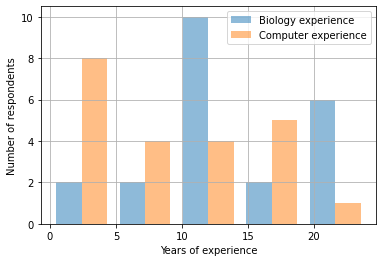

In [6]:
#Exploring the data - what does people's experience look like in a histogram? 

xp_hist = [expanded_backgrounds["years_experience_bio"], expanded_backgrounds["years_experience_computer"]]

plt.hist(xp_hist, bins=5,alpha=0.5,histtype="bar")
plt.grid(True)
plt.xlabel("Years of experience")
plt.ylabel("Number of respondents")
plt.legend(["Biology experience", "Computer experience"])
plt.savefig('figures/bio_computer_xp_years_bar.png',dpi=300)

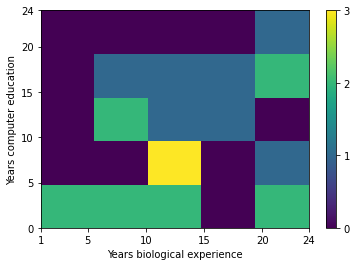

In [7]:
#Heatmap might be more useful than the above diagram
#This is the Figure 1 shown in the paper

plt.hist2d(expanded_backgrounds["years_experience_bio"], expanded_backgrounds["years_experience_computer"], bins=5, range=None, density=False)
colorbar = plt.colorbar(None, ticks=[0,1,2,3])
 
plt.clim(0,3)

plt.xlabel('Years biological experience')
plt.ylabel('Years computer education')

plt.xticks([1, 5, 10, 15, 20, 24])
plt.yticks([0, 5, 10, 15, 20, 24])

plt.savefig('figures/figure1.png',dpi=300)

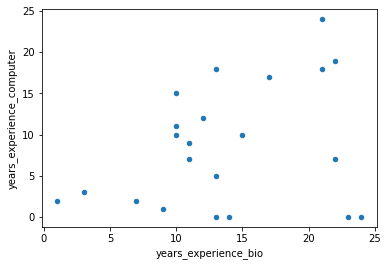

In [8]:
#bio xp (years) vs computer xp (years)
scatterplt = expanded_backgrounds.drop(["Respondent ID"], axis=1).plot.scatter(x="years_experience_bio", y="years_experience_computer")
scatterplt.figure.savefig('figures/bio_comp_xp_years_scatterplot.png',dpi=300)

### Formal education levels

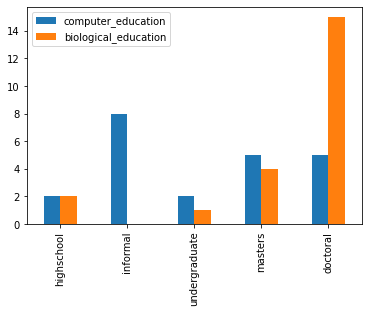

In [9]:
# bio xp (formal education) vs computer xp (formal education)

# First, set up the data categories
#question to self - did I include undergrad in this scale in the questionnaire??
degree_order = ["highschool", "informal", "undergraduate", "masters", "doctoral"]

# add category datatypes and make sure it's ordinal
expanded_backgrounds["biological_education"] = expanded_backgrounds["biological_education"].astype("category")
expanded_backgrounds["computer_education"] = expanded_backgrounds["computer_education"].astype("category")

expanded_backgrounds["computer_education"] = expanded_backgrounds["computer_education"].cat.set_categories(degree_order, ordered=True)
expanded_backgrounds["biological_education"] = expanded_backgrounds["biological_education"].cat.set_categories(degree_order, ordered=True)

#we want to just get the counts of who has which level. 
computer_formal = expanded_backgrounds["computer_education"].value_counts()
bio_formal = expanded_backgrounds["biological_education"].value_counts()

# in order to plot this as a bar chart, we want a df 
# with the categories as the labels and the values as rows
both_formal = pd.DataFrame([computer_formal, bio_formal])

# order based on the degree classification
both_formal = both_formal.T.sort_index()

#visualise
barchart = both_formal.plot.bar()
barchart.figure.savefig('figures/bio_computer_formal_bar.png',dpi=300)

In [10]:
# convert the formal education levels to a number in order to fake a plot...
# once I've looked it up online there might be a better way to do this? 
levels = {
    "highschool" : 1, 
    "informal" : 2, 
    "undergraduate" : 3, 
    "masters": 4, 
    "doctoral": 5
}


bio_numberwise = expanded_backgrounds["biological_education"]
computer_numberwise = expanded_backgrounds["computer_education"]

bio_numberwise = bio_numberwise.map(levels)
computer_numberwise = computer_numberwise.map(levels)
computer_numberwise


0     5
1     2
2     2
3     4
4     5
5     2
6     4
7     4
8     5
9     5
10    3
11    4
12    5
13    1
14    2
15    4
16    2
17    2
18    1
19    3
20    2
21    2
Name: computer_education, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

# Background - bio vs computing

In [11]:
formal_scatter_data = pd.DataFrame(data=[bio_numberwise,computer_numberwise])
formal_scatter_data = formal_scatter_data.transpose()

## Years of experience

,Respondent ID,Date Started,biological_education,bio_database_experience,software_tools_freetext,years_experience_bio,computer_education,computer_experience,programming_langs_free_text,bio_file_types_freetext,...,bio_files_type_python,bio_files_type_perl,bio_files_type_java,bio_files_type_rdbm,bio_files_type_functional_language,bio_files_type_graph_db,bio_files_type_semantic,bio_files_type_html,bio_files_type_js,bio_files_type_git
0,1,06/07/2019,highschool,galaxy = every_day;gnomad = never_heard;interm...,,10,doctoral,r_lang = every_month;python = every_day;perl =...,C/C++,GFF;FASTA;BAM;CSV / TSV,...,every_day,year_or_less,year_or_less,year_or_less,heard_of,heard_of,heard_of,year_or_less,year_or_less,every_week
1,2,06/07/2019,doctoral,galaxy = every_day;gnomad = never_heard;interm...,MaxQuant Every monthCardinal Everz weak,7,informal,r_lang = every_week;python = year_or_less;perl...,,mzml and imzml;FASTA;CSV / TSV,...,year_or_less,heard_of,heard_of,heard_of,heard_of,never_heard,never_heard,heard_of,heard_of,every_week
2,3,09/07/2019,doctoral,galaxy = every_month;gnomad = never_heard;inte...,BLAST - every weekPUBCHEM - every month,17,informal,r_lang = year_or_less;python = every_month;per...,MongoDBC/C++,GFF;FASTA;VCF;BAM;CSV / TSV;Excel / Google She...,...,every_month,every_day,heard_of,every_week,never_heard,never_heard,year_or_less,every_week,heard_of,every_day
3,4,16/08/2019,masters,galaxy = heard_of;gnomad = never_heard;intermi...,Omim - every monthClinVar - every monthENA - e...,11,masters,r_lang = year_or_less;python = every_day;perl ...,,FASTA;VCF;BAM;CSV / TSV;Excel / Google Sheets ...,...,every_day,every_month,year_or_less,every_day,heard_of,heard_of,heard_of,year_or_less,heard_of,every_week
4,5,21/08/2019,doctoral,galaxy = every_week;gnomad = heard_of;intermin...,"Ensembl REST API, BLAST, PyANI, CyVerse (US/UK)",21,doctoral,r_lang = every_day;python = every_day;perl = e...,"bash shell, GNU tools (awk, sed, curl, etc), jq","JSON, RDF;FASTA;VCF;BAM;CSV / TSV;Excel / Goog...",...,every_day,every_day,every_day,every_day,year_or_less,every_month,every_day,every_day,every_day,every_day
5,6,21/08/2019,doctoral,galaxy = heard_of;gnomad = never_heard;intermi...,BEAST - few times a yearPAML - every weekfigtr...,13,informal,r_lang = every_week;python = every_day;perl = ...,,GFF;FASTA;VCF;BAM;CSV / TSV;Excel / Google She...,...,every_day,heard_of,year_or_less,year_or_less,never_heard,heard_of,never_heard,year_or_less,never_heard,year_or_less
6,7,21/08/2019,doctoral,galaxy = every_day;gnomad = never_heard;interm...,Aequatus and GeneSeqToFamily: Daily,12,masters,r_lang = heard_of;python = every_week;perl = e...,,Newick;GFF;FASTA;VCF;BAM;CSV / TSV;Excel / Goo...,...,every_week,every_month,every_week,every_week,never_heard,never_heard,never_heard,every_week,every_week,every_week
7,8,21/08/2019,doctoral,galaxy = every_day;gnomad = year_or_less;inter...,BLAST (few times a year)BWA/BOWTIE/various RNA...,13,masters,r_lang = year_or_less;python = every_day;perl ...,,GFF;FASTA;VCF;BAM;CSV / TSV,...,every_day,year_or_less,year_or_less,every_week,heard_of,heard_of,heard_of,every_month,year_or_less,every_day
8,9,21/08/2019,doctoral,galaxy = year_or_less;gnomad = never_heard;int...,"Jalview. Clustal. RAxML, Cytoscape, Chimera, P...",15,doctoral,r_lang = year_or_less;python = every_week;perl...,,Phylip;FASTA;PDB,...,every_week,every_month,year_or_less,year_or_less,heard_of,never_heard,never_heard,every_month,heard_of,every_month
9,10,22/08/2019,doctoral,galaxy = year_or_less;gnomad = never_heard;int...,"Jalview Proviz, often for teaching",11,doctoral,r_lang = year_or_less;python = every_week;perl...,,I have not actively done research in the last ...,...,every_week,year_or_less,year_or_less,year_or_less,heard_of,never_heard,heard_of,year_or_less,year_or_less,every_week


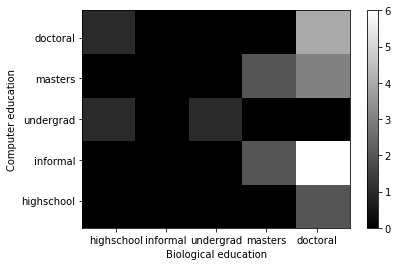

In [12]:
#visualise a scatterplot of years experience bio vs computational

xp_scatter_data = pd.DataFrame(data=[bio_numberwise,computer_numberwise])
xpx1_scatter_data = formal_scatter_data.transpose()

degreescale = ("highschool",
    "informal", 
    "undergrad", 
    "masters",
    "doctoral")

plt.hist2d(formal_scatter_data["biological_education"], formal_scatter_data["computer_education"], bins=5)
plt.xlabel('Biological education')
plt.ylabel('Computer education')


plt.xticks(np.linspace(1.5,4.5,5), degreescale)
plt.yticks(np.linspace(1.5,4.5,5), degreescale)
plt.gray()
plt.clim(0,6)
plt.colorbar()
plt.savefig('figures/bio_computer_formal.png',dpi=300)

expanded_backgrounds

In [13]:
# add participant identifiers to file
# not sure if we need file names or participant identifiers, let's just build both and see what nvivo likes

# variable to store the final response in as we build it
file_name = list()
participant_id = list()
prefix = ""

id_col = expanded_backgrounds["Respondent ID"]

for i in id_col:
    print(i, id_col[i-1])
    val = id_col[i-1]
    if (val < 10):
        prefix = "0"
    else:
        prefix = ""
    val = str(val)
        
    file_name.append("Files\\\\" + prefix + val + "_transcription")
    participant_id.append("Participant " + val)


participant_id = pd.DataFrame(participant_id)

participant_labelled_data = participant_id.join(expanded_backgrounds)

participant_labelled_data.to_csv("data/expanded_bg.csv",index=False)

participant_labelled_data

1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22


,0,Respondent ID,Date Started,biological_education,bio_database_experience,software_tools_freetext,years_experience_bio,computer_education,computer_experience,programming_langs_free_text,...,bio_files_type_python,bio_files_type_perl,bio_files_type_java,bio_files_type_rdbm,bio_files_type_functional_language,bio_files_type_graph_db,bio_files_type_semantic,bio_files_type_html,bio_files_type_js,bio_files_type_git
0,Participant 1,1,06/07/2019,highschool,galaxy = every_day;gnomad = never_heard;interm...,,10,doctoral,r_lang = every_month;python = every_day;perl =...,C/C++,...,every_day,year_or_less,year_or_less,year_or_less,heard_of,heard_of,heard_of,year_or_less,year_or_less,every_week
1,Participant 2,2,06/07/2019,doctoral,galaxy = every_day;gnomad = never_heard;interm...,MaxQuant Every monthCardinal Everz weak,7,informal,r_lang = every_week;python = year_or_less;perl...,,...,year_or_less,heard_of,heard_of,heard_of,heard_of,never_heard,never_heard,heard_of,heard_of,every_week
2,Participant 3,3,09/07/2019,doctoral,galaxy = every_month;gnomad = never_heard;inte...,BLAST - every weekPUBCHEM - every month,17,informal,r_lang = year_or_less;python = every_month;per...,MongoDBC/C++,...,every_month,every_day,heard_of,every_week,never_heard,never_heard,year_or_less,every_week,heard_of,every_day
3,Participant 4,4,16/08/2019,masters,galaxy = heard_of;gnomad = never_heard;intermi...,Omim - every monthClinVar - every monthENA - e...,11,masters,r_lang = year_or_less;python = every_day;perl ...,,...,every_day,every_month,year_or_less,every_day,heard_of,heard_of,heard_of,year_or_less,heard_of,every_week
4,Participant 5,5,21/08/2019,doctoral,galaxy = every_week;gnomad = heard_of;intermin...,"Ensembl REST API, BLAST, PyANI, CyVerse (US/UK)",21,doctoral,r_lang = every_day;python = every_day;perl = e...,"bash shell, GNU tools (awk, sed, curl, etc), jq",...,every_day,every_day,every_day,every_day,year_or_less,every_month,every_day,every_day,every_day,every_day
5,Participant 6,6,21/08/2019,doctoral,galaxy = heard_of;gnomad = never_heard;intermi...,BEAST - few times a yearPAML - every weekfigtr...,13,informal,r_lang = every_week;python = every_day;perl = ...,,...,every_day,heard_of,year_or_less,year_or_less,never_heard,heard_of,never_heard,year_or_less,never_heard,year_or_less
6,Participant 7,7,21/08/2019,doctoral,galaxy = every_day;gnomad = never_heard;interm...,Aequatus and GeneSeqToFamily: Daily,12,masters,r_lang = heard_of;python = every_week;perl = e...,,...,every_week,every_month,every_week,every_week,never_heard,never_heard,never_heard,every_week,every_week,every_week
7,Participant 8,8,21/08/2019,doctoral,galaxy = every_day;gnomad = year_or_less;inter...,BLAST (few times a year)BWA/BOWTIE/various RNA...,13,masters,r_lang = year_or_less;python = every_day;perl ...,,...,every_day,year_or_less,year_or_less,every_week,heard_of,heard_of,heard_of,every_month,year_or_less,every_day
8,Participant 9,9,21/08/2019,doctoral,galaxy = year_or_less;gnomad = never_heard;int...,"Jalview. Clustal. RAxML, Cytoscape, Chimera, P...",15,doctoral,r_lang = year_or_less;python = every_week;perl...,,...,every_week,every_month,year_or_less,year_or_less,heard_of,never_heard,never_heard,every_month,heard_of,every_month
9,Participant 10,10,22/08/2019,doctoral,galaxy = year_or_less;gnomad = never_heard;int...,"Jalview Proviz, often for teaching",11,doctoral,r_lang = year_or_less;python = every_week;perl...,,...,every_week,year_or_less,year_or_less,year_or_less,heard_of,never_heard,heard_of,year_or_less,year_or_less,every_week
